In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab4.ipynb")

# Coding lab \#4

```{grid} 2 2 2 2 
**2D elements** 
:::{figure} figures/AshesiETHLogo.png
:align: right
:width: 300px
:::
```

:::{admonition} How to use this notebook?
This notebook is made of text cells and code cells. The code cells have to be **executed** to see the result of the program. \
To execute a cell, simply select it and click on the "play" button \(&#9658;\) in the tool bar just above the notebook, or type `shift+enter`
It is important to execute the code cells in their order of appearance in the notebook.

**As a first step**: execute the very first OtterGrader code cell at the very top of this notebook. 

If you are running into any problems, try restarting the kernel and then see if the issue persist. 
:::

## Learning Goals

After using this notebook, you should be able to:
* perform FE computations under the plane stress assumptions using CST (Constant Strain Triangular) elements
* understand why mesh refinement is necessary

## Problem Statement

The objective of this coding lab is to write your own finite element code to simulate linear elastic boundary value problems in 2D (under plane stress assumptions). 
Plane stress means that we are dealing with a thin object loaded within its own median plane. 
Examples include bi-axial testing of thin samples, or a spanner used to tighten a bolt.
To  model these structures, we will use constant strain triangles (CSTs), whose formulation was derived in Section 16 of the lecture notes (see especially Sections 16.3 and 16.3.1 for the $\boldsymbol{B}$-matrix, stiffness matrix, internal forces, etc. and Section 1.4 (particularly equations 1.32) for matrix $\boldsymbol{E}=\mathbb{C}$).

%<img src="figures/P4_spanner04.png" alt="spanner" style="width:200px;"/>
%<!-- <p style="font-style:italic;">Figure 1: spanner </p> -->

```{figure} figures/P4_spanner04.png
:name: spannerFE
:alt: spanner FE
:class: bg-primary
:width: 100px"
:align: center

```

<div style="text-align: center"> <sup><sub> image credit: http://mae.uta.edu/~lawrence/ansys/solutions/wrench/wrench.htm</sub></sup>  </div>

___
## problem 1 a)


:::{admonition} submission requirement
:class: tip

A person is trying to balance on a road sign (a very bad idea!), which is fully clamped on the left-hand-side (along $x_1 = 0$).
At a point in time the person's weight distribution can be approximated by a distributed load as shown in the figure below.
To model the deformation of the road sign under this distributed load with the finite element method, we decide to discretize the domain into 16 CSTs, as shown in the figure below. 

```{figure} figures/lab4_plate_nodes_0.png
:name: roadSign
:alt: plane stress road sign
:class: bg-primary
:width: 400px
:align: center

```
We now solve for the deformation of and stresses within the road sign under the load by the FEM (assuming plane stress). 
The dimensions are given by $a = 0.25$m and $t=0.1$m, Young's modulus and Poisson's ratio are $E_y = 2$GPa and $\nu = 0.3$, respectively.
*Assume* that the external forces on nodes 1, 2 and 3 (equivalent to the distributed load) have components 

$F^1_2 = -1000$N, $F^2_2 = -2000$N, and $F^3_2 = -800$N. 

Follow the intstructions in the coding section below and input all missing information as indicated, to solve this problem under the **plane stress** assumption using **CST**s. Then follow the instructions in the pre-processing section to complete problem 1. 
:::

___

# coding

For this, we need to import some useful Python libraries.

**Execute the code cell below** so that the necessary libraries are imported.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.legend_handler import HandlerTuple
import os
import subprocess
import meshio
from lib.plotting_functions import plot_original_and_displaced_structure, plot_von_Mises_stress_distribution,plot_h_vs_Sigma
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
# Enable inline plotting in Jupyter Notebook
%matplotlib inline
# And display a message once all libraries are imported
print("Libraries imported.")

Libraries imported.


### pre-processing

In [3]:
def input_definition(problem):
    ###########################################################################################################
    if problem == 1: 

        # fill out all the missing parts:

        # coordinates of the global nodes:
        a = 0.25
        

        nodal_positions = np.array([[0, 2*a],
                                   [a, 2*a],
                                   [2*a, 2*a],
                                   [3*a, 2*a],
                                   [4*a, 2*a],
                                   [0, a],
                                   [a, a],
                                   [2*a, a],
                                   [3*a, a],
                                   [4*a, a],
                                   [0, 0],
                                   [a, 0],
                                   [2*a, 0],
                                   [3*a, 0],
                                   [4*a, 0]])
        
        # local-to-global map / node connectivity

        nodal_connectivities = np.array([[1, 0, 5],
                                        [5, 6, 1],
                                        [2, 1, 6],
                                        [6, 7, 2],
                                        [2, 7, 3],
                                        [7, 8, 3],
                                        [3, 8, 4],
                                        [8, 9, 4],
                                        [5, 10, 6],
                                        [10, 11, 6],
                                        [6, 11, 7],
                                        [11, 12, 7],
                                        [7, 12, 8],
                                        [12, 13, 8],
                                        [8, 13, 9],
                                        [13, 14, 9]
                                       ]) 
        
        
        #Neumann_BCs = np.array([[node number, in direction 0/1 , non-zero force applied (we will initialize the force vector with zeros)]]) 
        #                                     0: x1 - direction 
        #                                     1: x2 - direction 
                          
        Neumann_BCs = np.array([[1,1,-1000],
                                [2,1,-2000],
                                [3,1,-800]
                               ])
        
        #Dirichlet_BCs = np.array([[node number, in dircection 0 or 1, prescribed displacement]])
        #                                        0: x1 - direction 
        #                                        1: x2 - direction 
        
        Dirichlet_BCs = np.array([[0,0,0],
                                  [0,1,0],
                                  [5,0,0],
                                  [5,1,0],
                                  [10,0,0],
                                  [10,1,0]
                                 ])

        # material properties:
        v  = 0.3  # Poisson's ratio
        t  = 0.1  # thickness
        Ey = 2E9  # Young's Modulus [N/m^2]  
    ###########################################################################################################
    elif problem == 2:    
        # you can ignore this section for now, we will get back to this later on.
        
        # Enter h, sigma1, sigma2:
        h = 0.04
        sigma1 = 10
        sigma2 = 0
        
        from lib.P4_Problem2_Input import P4_Problem2_Input
        
        nodal_positions, nodal_connectivities, Dirichlet_BCs, Neumann_BCs, Ey, v, t = \
            P4_Problem2_Input(h, sigma1, sigma2)
    ###########################################################################################################
    
    else:
        print('please enter 1 or 2!')
    return nodal_positions, nodal_connectivities, Dirichlet_BCs, Neumann_BCs, Ey, v, t

### select input

We define the two problems of this project below in this input section. 


:::{admonition} attention
:class: attention

Make sure to enter the problem number you are solving below. Ensure that **problem = 1 for your submission**!
:::



In [4]:
problem = 1
nodal_positions, nodal_connectivities, Dirichlet_BCs, Neumann_BCs, Ey, v, t   = input_definition(problem)

In [5]:
grader.check("input")

input results: All test cases passed!
input - 1 message: problem 1 - nice, you seem to have defined the tested input variables for problem 1 correctly.

### set-up

This should be familiar to you by now: you are only asked to construct the 
1. material stiffness matrix $\boldsymbol{E}_{\text{plane stress}}$ called ```E_matrix``` in the code and
2. ```elment_dof_connectivity``` matrix below: 

In [6]:
# ----------------------------------------------------------------------------------------------------------#
#                                          Set up FE
# ----------------------------------------------------------------------------------------------------------#
no_dofs_per_node = 2                              # number of dofs per node
no_global_nodes  = nodal_positions.shape[0]       # number of global nodes
no_global_dofs   = no_global_nodes * no_dofs_per_node # number of global dofs
no_elements      = nodal_connectivities.shape[0]  # number of elements
no_Neumann_BCs   = Neumann_BCs.shape[0]           # number of external loads applied
no_Dirichlet_BCs = Dirichlet_BCs.shape[0]         # number of Dirichlet boundary conditions

# TODO: construct the material stiffness matrix plane stress:
E_matrix = (Ey/(1-v**2))*np.array([[1,v,0],
                                   [v,1,0],
                                   [0,0,(1-v)/2]
                                  ])
node1e = nodal_connectivities[:,0]
node2e = nodal_connectivities[:,1]
node3e = nodal_connectivities[:,2]

# TODO: construct the element_dof_connectivity matrix generically (i.e. using only variable names):
element_dof_connectivity = np.column_stack([node1e*no_dofs_per_node,node1e*no_dofs_per_node+1,node2e*no_dofs_per_node,node2e*no_dofs_per_node+1,node3e*no_dofs_per_node,node3e*no_dofs_per_node+1])

print(element_dof_connectivity)

[[ 2  3  0  1 10 11]
 [10 11 12 13  2  3]
 [ 4  5  2  3 12 13]
 [12 13 14 15  4  5]
 [ 4  5 14 15  6  7]
 [14 15 16 17  6  7]
 [ 6  7 16 17  8  9]
 [16 17 18 19  8  9]
 [10 11 20 21 12 13]
 [20 21 22 23 12 13]
 [12 13 22 23 14 15]
 [22 23 24 25 14 15]
 [14 15 24 25 16 17]
 [24 25 26 27 16 17]
 [16 17 26 27 18 19]
 [26 27 28 29 18 19]]


In [7]:
grader.check("setUpFE")

setUpFE results: All test cases passed!
setUpFE - 1 message: nice, your E-matrix seems to be correct!

### define functions

As we have seen in Coding Lab 3, let's **write two functions** to make our life easier: fill out the missing information below to compute 
1. the $\boldsymbol{B}_e$ - matrix (per element) and
2. the element stiffness matrix $\boldsymbol{K}_e$:

In [8]:
def compute_Be(nodal_positions, node1e, node2e, node3e):
    
    # write your code here to compute the B-matrix per element,
    # using the inputs provided: namely the nodal_positions and node1e, node2e, node3e, 
    # which are the three nodes associated with the current element. 

    x1,y1 = nodal_positions[node1e]
    x2,y2 = nodal_positions[node2e]
    x3,y3 = nodal_positions[node3e]
    y23 = y2-y3
    y31 = y3-y1
    y12 = y1-y2
    x32 = x3-x2
    x13 = x1-x3
    x21 = x2-x1
    x31 = x3-x1
    y21 = y2-y1

    #print(x1)

    Ae = 0.5*((x21*y31)-(x31*y21))
    Be = (1/(2*Ae))*np.array([[y23,0,y31,0,y12,0],
                              [0,x32,0,x13,0,x21],
                              [x32,y23,x13,y31,x21,y12]
                             ])
    
    return Be

In [9]:
grader.check("Be")

Be results: All test cases passed!
Be - 1 message: seems like your function to compute the Be matrix works correctly.

In [10]:
def compute_element_stiffnes_matrix(nodal_positions, node1e, node2e, node3e, E_matrix, t):
    
    # write your code here to compute the elemental stiffness matrix Ke
    # using the inputs provided: namely the nodal_positions and node1e, node2e, node3e, 
    # which are the three nodes associated with the current element, 
    # as well as the E-matrix and the thickness t of the element.
    Be = compute_Be(nodal_positions, node1e, node2e, node3e)
    x1,y1 = nodal_positions[node1e]
    x2,y2 = nodal_positions[node2e]
    x3,y3 = nodal_positions[node3e]

    x21 = x2-x1
    y31 = y3-y1
    x31 = x3-x1
    y21 = y2-y1

    Ae = 0.5*(x21*y31-x31*y21)
    element_stiffness_matrix = (Be.T@E_matrix@Be)*t*Ae

    
    return element_stiffness_matrix

In [11]:
grader.check("Ke")

Ke results: All test cases passed!
Ke - 1 message: seems like your function to compute the Ke matrix works correctly.

Applying the boundary conditions and solving is given here in a function. We wrote this completely generically in coding lab 3, **so no changes are required**. You can click on the three dots to see details of the function.

In [12]:
def apply_BCs_and_solve(global_stiffness_matrix):
    import time 
    # Convert to sparse 
    global_stiffness_matrix = csr_matrix(global_stiffness_matrix)

    # Compute DOFs
    non_zero_Neumann_BCs_dofs = (no_dofs_per_node * Neumann_BCs[:, 0].astype(int) 
                                 + Neumann_BCs[:, 1].astype(int))
    
    Dirichlet_BCs_dofs = (no_dofs_per_node * Dirichlet_BCs[:, 0].astype(int)
                          + Dirichlet_BCs[:, 1].astype(int))
    
    # Use np.setdiff1d for fast difference computation
    Neumann_BCs_dofs = list(set(range(no_global_dofs)) - set(Dirichlet_BCs_dofs))
    # Initialize global vectors
    global_force_vector        = np.zeros(no_global_dofs)
    global_displacement_vector = np.zeros(no_global_dofs)

    # Apply Neumann and Dirichlet BCs
    global_force_vector[non_zero_Neumann_BCs_dofs] = Neumann_BCs[:, 2]
    global_displacement_vector[Dirichlet_BCs_dofs] = Dirichlet_BCs[:, 2]

    # Extract submatrices
    KFF = global_stiffness_matrix[np.ix_(Neumann_BCs_dofs, Neumann_BCs_dofs)]
    KFE = global_stiffness_matrix[np.ix_(Neumann_BCs_dofs, Dirichlet_BCs_dofs)]
    
    UE = global_displacement_vector[Dirichlet_BCs_dofs]
    FF = global_force_vector[Neumann_BCs_dofs]

    # Solve the reduced system using sparse solver
    rhs = FF - KFE @ UE  # Compute this first to avoid redundant computation
    UF = spsolve(KFF, rhs)
    
    # Store results
    global_displacement_vector[Neumann_BCs_dofs] = UF

    # Solve for reaction forces
    global_force_vector = global_stiffness_matrix@global_displacement_vector

    return global_displacement_vector, global_force_vector   

### assemble global stiffness matrix & apply BC's and solve problem
We loop over all elements and compute the elemental stiffness matrices and assemble these to the correct positions into the global stiffness matrix, **no changes required**. Simply execute this code block.

Enforcing the essential and natural boundary conditions and computing the global displacement and force vectors.
**Note:** Since we wrote this section generically in the previous projects, we can reuse it here and **do not have to apply any changes**, regardless if we use bar or beam or CST elements. We simply make use of the function we defined earlier on. Execute the code cell below.

In [13]:
# ----------------------------------------------------------------------------------------------------------#
#                                                ASSEMBLE K
# ----------------------------------------------------------------------------------------------------------#
#Initialize global stiffness matrix to the correct size:
global_stiffness_matrix = np.zeros((no_global_dofs, no_global_dofs))

# Assemble global stiffness matrix
# Loop over all elements -> compute elemental stiffness matrix -> assemble global stiffness matrix
for e in range(no_elements):
    node1e = nodal_connectivities[e, 0]
    node2e = nodal_connectivities[e, 1]
    node3e = nodal_connectivities[e, 2]
    element_stiffness_matrix = compute_element_stiffnes_matrix(nodal_positions, node1e, node2e, node3e, E_matrix, t)

    # Assemble Ke into Kglobal:
    global_stiffness_matrix[np.ix_(element_dof_connectivity[e], element_dof_connectivity[e])] += element_stiffness_matrix
# ----------------------------------------------------------------------------------------------------------#
#                                               APPLYING BCs & SOLVING
# ----------------------------------------------------------------------------------------------------------#
# The computation of the global displacement and force vectors does not require any changes.
global_displacement_vector, global_force_vector = apply_BCs_and_solve(global_stiffness_matrix)
# ----------------------------------------------------------------------------------------------------------#

## problem 1 b)
:::{admonition} submission requirement
:class: tip

Now that we solved problem 1 using CST elements, i.e. you computed all nodal displacements and forces acting on the support of the sign, we do some post-processing:


```{figure} figures/lab4_plate_stress.png
:name: roadSign
:alt: plane stress road sign
:class: bg-primary
:width: 400px
:align: center

```

Compute the **stress component** $\sigma_{11}$  in the **two elements marked in red and labelled *upper* and *lower*** in the above figure and print these to screen. 

Finally, use the provided plotting function to plot the initial and deformed structure.
:::


the stress sigma_11_upper = 188118.84 Pa
the stress sigma_11_lower = -183703.29 Pa


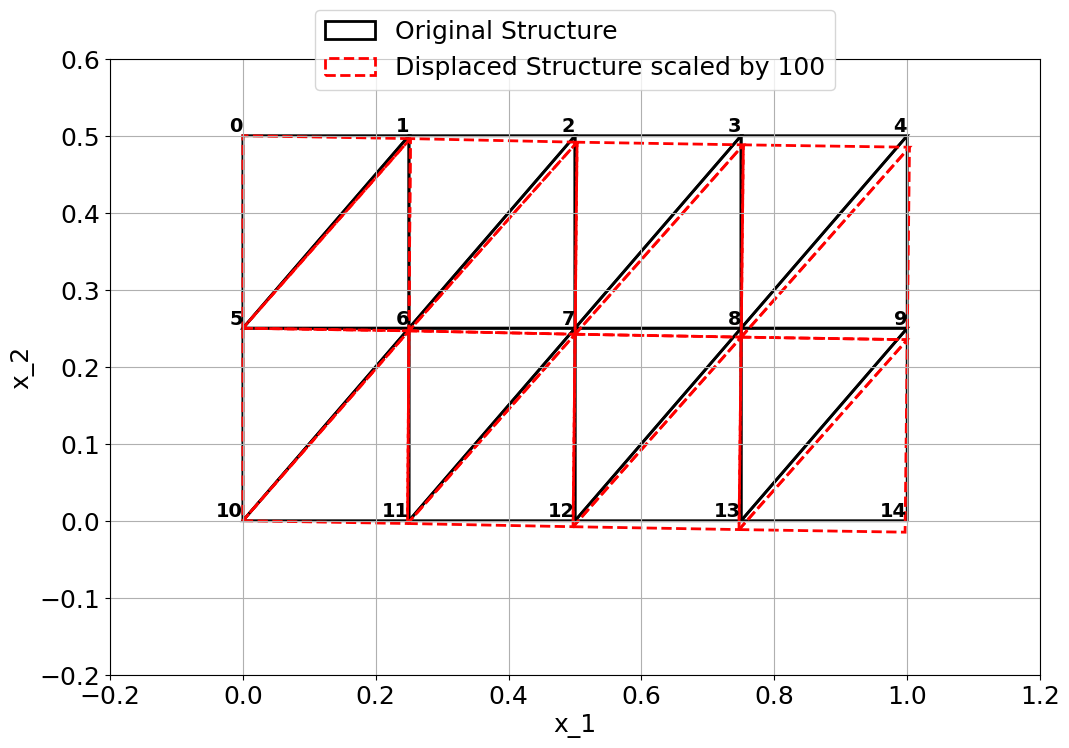

In [14]:
# ----------------------------------------------------------------------------------------------------------#
#                                        POST-PROCESSING
# ----------------------------------------------------------------------------------------------------------#
if problem == 1:

    
    upper_element = 0
    lower_element = 9


    upper_node1e = nodal_connectivities[upper_element,0]
    upper_node2e = nodal_connectivities[upper_element,1]
    upper_node3e = nodal_connectivities[upper_element,2]

    Be_upper = compute_Be(nodal_positions, upper_node1e, upper_node2e, upper_node3e)

    upper_dof = [upper_node1e*no_dofs_per_node,upper_node1e*no_dofs_per_node+1,upper_node2e*no_dofs_per_node,upper_node2e*no_dofs_per_node+1,upper_node3e*no_dofs_per_node,upper_node3e*no_dofs_per_node+1]

    upper_displacement = global_displacement_vector[upper_dof]

    upper_stress = E_matrix@Be_upper@upper_displacement

    
    lower_node1e = nodal_connectivities[lower_element,0]
    lower_node2e = nodal_connectivities[lower_element,1]
    lower_node3e = nodal_connectivities[lower_element,2]

    Be_lower = compute_Be(nodal_positions, lower_node1e, lower_node2e, lower_node3e)
    
    lower_dof = [lower_node1e*no_dofs_per_node,lower_node1e*no_dofs_per_node+1,lower_node2e*no_dofs_per_node,lower_node2e*no_dofs_per_node+1,lower_node3e*no_dofs_per_node,lower_node3e*no_dofs_per_node+1]

    lower_displacement = global_displacement_vector[lower_dof]

    lower_stress = E_matrix@Be_lower@lower_displacement

    
    sigma_11_upper = upper_stress[0]
    sigma_11_lower = lower_stress[0]
    
    print(f'the stress sigma_11_upper = {sigma_11_upper:.2f} Pa')
    print(f'the stress sigma_11_lower = {sigma_11_lower:.2f} Pa')

    # simply execute this code block to see the initial and deformed structure thanks to the provided plotting function:        
    scale_factor = 100 # we scale the deformed solution so that it becomes visible seeing that we are working with small displacements           
    plot_original_and_displaced_structure(nodal_positions, global_displacement_vector, nodal_connectivities, scale_factor)

___
## problem 2 a)
:::{admonition} submission requirement
:class: tip
Now we are all set to solve a real-world problem. We would like to know how well our FE code performs when it comes to stress distributions around a hole in a plate that is loaded remotely (see the figure below). The circumferential stress along the edge of a circular hole in a 2D infinite plate under remote loading was found analytically in the classical work of Savin (1961), referencing back to Muskhelishvili (1934), as

$$
	\sigma_\text{circ}(\theta)=(\sigma_1+\sigma_2)-2(\sigma_1-\sigma_2)\cos(2\theta),
$$

where $\sigma_{1,2}$ are the remotely applied stresses in the $x_{1,2}$-directions (see the figure), and the position on the circumference is indicated by $\theta$, the angle measured from the horizontal axis. 
Notice that in the special case $\sigma_{2}=0$ (uniaxial loading), the maximum stress is $\sigma_\text{circ}(\tfrac{\pi}{2})=3\sigma_1$ and $\sigma_\text{circ}(0)=-\sigma_1$.

Let us solve this boundary problem numerically with our FE code.
By symmetry, it is sufficient to simulate only one quadrant of the problem with uniform tractions applied on two edges and sliding essential boundary conditions applied on the other two edges, as shown in the figure. 

```{figure} figures/infinitePlate-eps-converted-to.png
:name: sketch
:alt: infinite plate sketch
:class: bg-primary
:width: 300px
:align: center

```

```{figure} figures/infinitePlateFE.png
:name: plateFE
:alt: infinite plate FE
:class: bg-primary
:width: 400px
:align: center

```

%<img src="figures/infinitePlate-eps-converted-to.png" alt="infinite plate sketch" style="width:300px;"/>
%<!-- <p style="font-style:italic;">Figure 3: infinite plate sketch </p> -->


%<img src="figures/infinitePlateFE.png" alt="infinite plate FE" style="width:400px;"/>
%<!-- <p style="font-style:italic;">Figure 4: infinite plate FE </p> -->

Simply specify $h,\sigma_1,\sigma_2$ in the input section and select problem = 2 to run the problem.
Young's modulus, Poisson's ratio and plate thickness are $E = 10^3$ N/m$^2$, $\nu = 0.3$ and $t = 1$ m , respectively.
Use $\sigma_1 = 10$ N/m$^2$ and $\sigma_2 = 0$ N/m$^2$.
You are aslo required to input the $h$-factor, which governs the element size around the hole.
For lower values of $h$ the mesh is more refined.
Please note that the underlying mesh refinement algorithm may produce a slightly different mesh when you run your simulation multiple times using the same value for $h$.
Run your FE code with $h = 0.08$ (you should already see some mesh refinement around the hole) and compute all element strains and stresses.
For each element, we also calculate the von Mises stress

$$
	\sigma_\text{vM} = \sqrt{\sigma_{11}^2 - \sigma_{11} \sigma_{22} + \sigma_{22}^2 + 3 \sigma_ {12}^2 },
$$

where we assume plane stress conditions ($\sigma_{33}=0$). 

The von Mises stress is an effective stress measure, which is a scalar quantity.
On the hole's circumference, the von Mises stress and the analytical solution coincide ($\sigma_{\text{circ}}=\sigma_{\text{vM}}$) since there is only one non-zero stress component.
We can verify that the maximum von Mises stress on the circumference that you compute is found in the outermost element on the circumference (at $\theta = \tfrac{\pi}{2}$), which is in agreement with the analytical solution.

---
**Input** the required $h,\sigma_1,\sigma_2$ in the pre-processing section: use $\sigma_1 = 10$ N/m$^2$ and $\sigma_2 = 0$ N/m$^2$ and  $h = 0.08$. 

Further, **select problem = 2** in the select input section.

For this $h = 0.08$, **calculate the strains and stresses for each element** and from those the **von Mises stress for each element** in the post-processing section below.
Use the provided plotting function to plot the von Mises stress throughout the domain and verify that the maximum von Mises stress indeed appears at the expected location.
:::

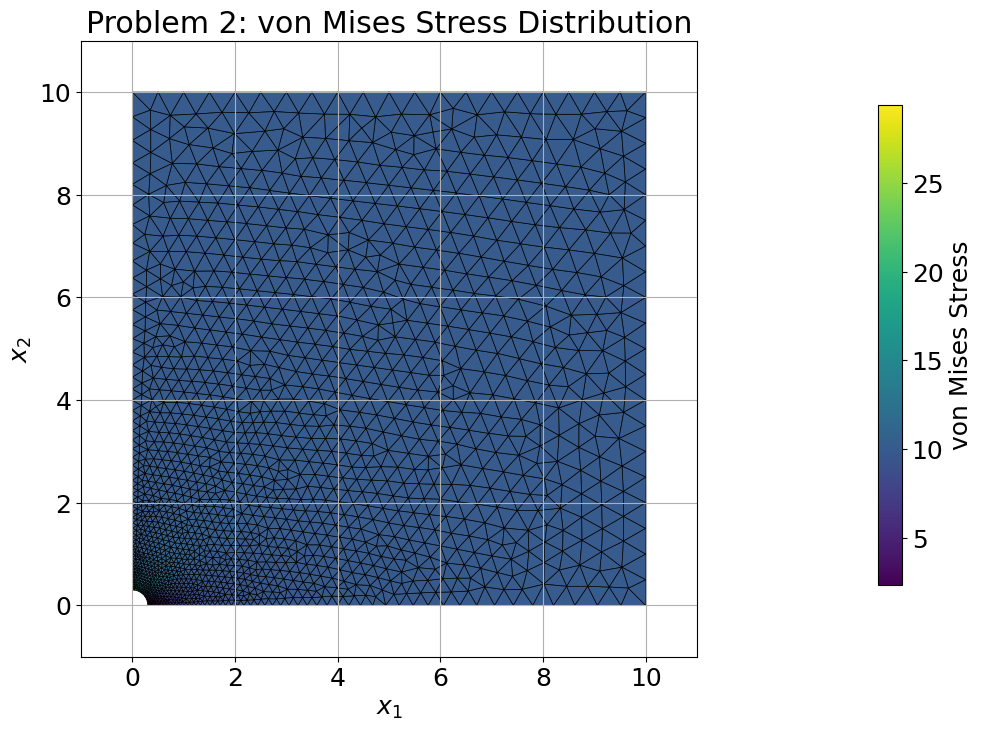

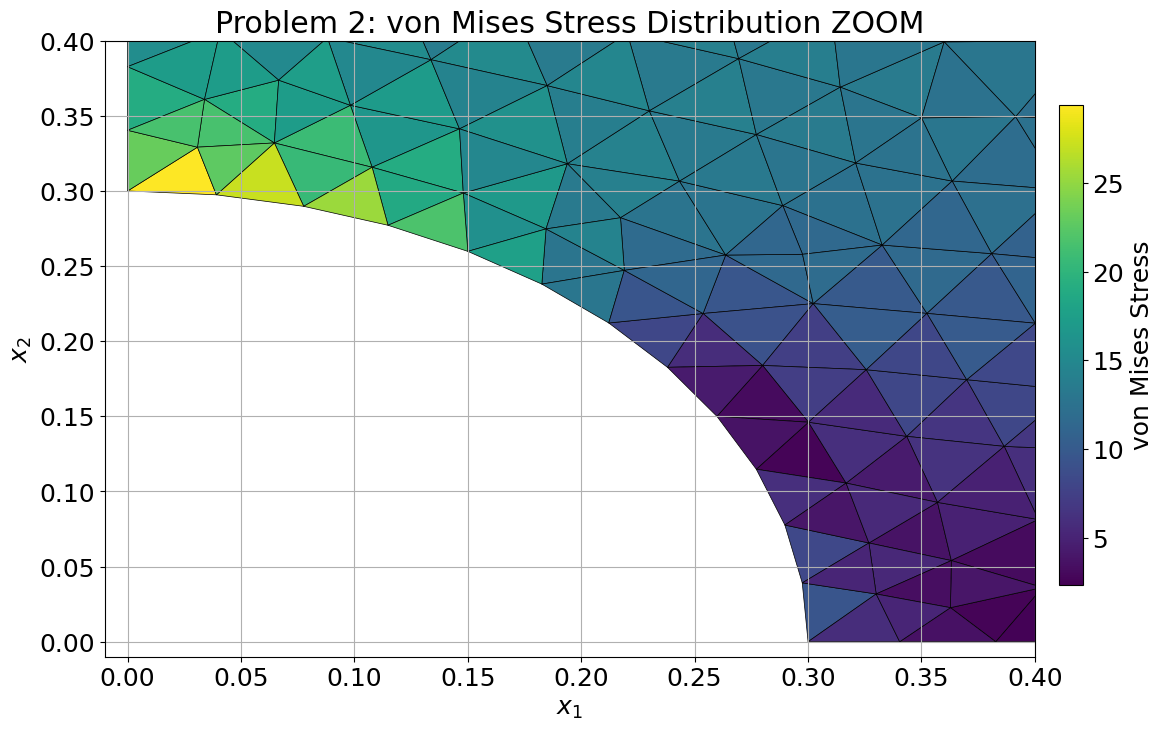

Maximum von Mises stress is 29.41 Pa


In [104]:
if problem == 2:  
    # initialize a vector to store the von Mises stress per element
    # no changes required
    stress_von_Mises = np.zeros((no_elements, 1))
     
    
    # # compute the von Mises stress per element and store it inside stress_von_Mises:
    for e in range(no_elements):
        node1e = nodal_connectivities[e,0]
        node2e = nodal_connectivities[e,1]
        node3e = nodal_connectivities[e,2]

        Be = compute_Be(nodal_positions, node1e, node2e, node3e)

        dof = [node1e*no_dofs_per_node,node1e*no_dofs_per_node+1,node2e*no_dofs_per_node,node2e*no_dofs_per_node+1,node3e*no_dofs_per_node,node3e*no_dofs_per_node+1]

        displacement = global_displacement_vector[dof]

        stress = E_matrix@Be@displacement

        #print(stress)
        
        # write your code here
        sigma11,sigma22,sigma12 = stress
        sigma = (sigma11**2)-(sigma11*sigma22)+(sigma22**2)+(3*sigma12**2)
        stress_von_Mises[e] = np.sqrt(sigma)
    
    # provided plotting function
    plot_von_Mises_stress_distribution(nodal_positions,nodal_connectivities, stress_von_Mises)

    # printing the maximum stress to screen is provided here:
    print(f"Maximum von Mises stress is {np.max(stress_von_Mises):.2f} Pa")
    

## problem 2 b)

:::{admonition} submission requirement
:class: tip
We now want to refine the mesh around the hole. 
Run your code two more times, each time decreasing the value of $h$, using $h = 0.04$ and $h = 0.01$, respectively.
Does the FE solution improve with $h$-refinement as compared to the analytical solution?  

Use the predefined structure below to save the maximum von Mises stress (which is displayed above) corresponding to the respective level of refinement.
:::

In [105]:
h_values                = np.array([ 0.01,0.04, 0.08 ])
# uncomment the following line of code and fill in the numerical values of the corresponding max. von Mises stress
# simply copy the value that you print to screen above.
corr_max_von_Mises_stress = np.array([29.90,29.41, 27.47 ]) # [Pa]

## problem 2 c)
:::{admonition} submission requirement
:class: tip
Now use the provided plotting functions to show the plot $h$ vs. $\sigma_{\text{vM max}}$.
The plot includes a line indicating the exact solution.

Simply uncomment the code cell below and run it:

:::

<!-- BEGIN QUESTION -->



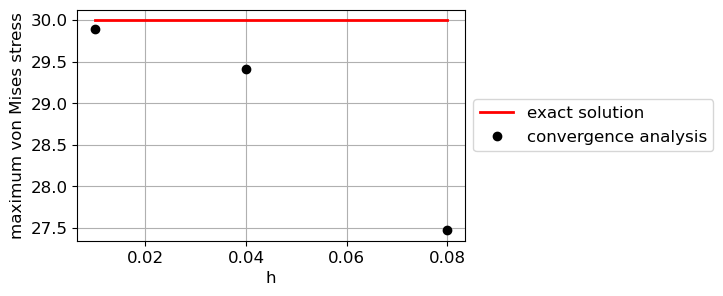

In [106]:
# simply uncomment the code and execute this code cell:
plot_h_vs_Sigma(h_values,corr_max_von_Mises_stress)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## problem 2 d)

:::{admonition} submission requirement
:class: tip
Comment on the accuracy/convergence of the FE-code in the space provided below. What trend do you observe? Is this expected? Why/why not?
:::

The convergence plot shows that the maximum von Mises stress approaches the exact analytical solution as the mesh is refined (i.e., as h decreases). This indicates that the FE code is accurate and convergent. The coarse mesh underestimates the stress due to its limited ability to capture stress gradients, but finer meshes yield results that are closer to the exact value. I expected this behavior for linear triangular (CST) elements, which exhibit gradual convergence in stress as element size decreases.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

***

## Closing remarks

When you reach this part of the script, your code should be running just fine.  
Further, you have taken some time to interpret some of the results. 

To close off this assignment on 2D elements, write down three points of what you have learned during this project in the provided space below.

As a final point, you can also give an indication of how long it took you to complete this assignment. 

- I learned about how to perform FE computations under the plane stress assumptions using CST (Constant Strain Trinagular) elements
- I learned about how to compute element stresses from the displacement vector, B-matrix, and the elastic stiffness matrix as well as the Von Mises stress.
- I learned that the finer a mesh is, the closer the FE result to the exact value.

In [15]:
grader.check("Check saved problem 1 for submission")

Check saved problem 1 for submission results: All test cases passed!
Check saved problem 1 for submission - 1 message: great, you ran problem = 1 as required for submission.

<!-- END QUESTION -->

:::{admonition} important
:class: attention

**Run** and **save** your code with **problem = 1** in code cell 4 before submitting your coding-lab-4 folder with all its dependencies through Moodle!

Best of luck!

:::